In [5]:
import os
import re
import tifffile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from skimage import feature
from bigfish import detection

In [6]:
# Assumes the folders are present in the CWD
path_input = "./img_RNAscope"
path_output = "./output_RNAscope"
path_figures = "./figures_RNAscope"
path_fwhm = "./fwhm_RNAscope"

paths = os.listdir(path_input)
paths = [p for p in paths if p.endswith(".tif")]
print(paths)

['Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', 'Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch2_561.tif', 'Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch4_405.tif', 'Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch3_488.tif', 'Beads_300nm_rainbow_100X_2024-12-10_15.07.43_ch4_405.tif', 'Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch1_637.tif', '_Beads_300nm_rainbow_40X_2024-12-10_14.19.50_X418_Y130_W332_H332.tif', 'Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch1_637.tif', 'Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch3_488.tif', 'Beads_300nm_rainbow_100X_2024-12-10_15.07.43_ch3_488.tif', 'Beads_300nm_rainbow_100X_2024-12-10_15.07.43_ch2_561.tif', 'Beads_300nm_rainbow_100X_2024-12-10_15.07.43_ch1_637.tif', 'Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch2_561.tif']


In [7]:
np.int = int # Fixes compute_snr_spots using the now deprecated numpy.int https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [10]:
RADIUS_FACTOR = 2.0
PIXEL_SIZE = {"100X": (381.0, 120.5, 120.5), "60X": (384.6 , 201.1, 201.1), "40X": (392.2 , 301.5, 301.5)}   # in nanometer (one value per dimension zyx)
SPOT_RADIUS = {k:tuple((RADIUS_FACTOR * d for d in v)) for k,v in PIXEL_SIZE.items()}  # in nanometer (one value per dimension zyx)
THRESHOLD_LOW = 5000
MIN_DIST={"100X":5, "60X":3, "40X":2}
ob_re =  re.compile(r".*rainbow_([0-9]+X)_2024.*")

In [12]:
# Identify peaks as local maxima  and calculate signal to noise ratio with big-fish (https://big-fish.readthedocs.io/en/stable/detection/spots.html#compute-signal-to-noise-ratio)
summary = []
for path in paths:
    img_path = os.path.join(path_input, path)
    output_path = os.path.join(path_output, path.replace(".tif", ".csv"))

    img = tifffile.imread(img_path)
    clean_img = np.copy(img)
    clean_img[clean_img < THRESHOLD_LOW] = 0 # Remove all pixels < THRESHOLD_LOW

    # Select pixel size, minimum distance between spots and spot radius according to the objective used
    obj = ob_re.match(path).group(1)
    px = PIXEL_SIZE[obj]
    sr = SPOT_RADIUS[obj]
    md = MIN_DIST[obj]
    
    spots = feature.corner_peaks(clean_img, min_distance=md,
                                   threshold_abs=None,
                                   footprint = None,
                                   threshold_rel=None,
                                   exclude_border=False)
    df = pd.DataFrame(spots)
    df.to_csv(path_or_buf = output_path, sep=',', na_rep='', float_format=None, columns=None, header=True, index=False)


    snr = detection.compute_snr_spots(img, spots[:, 0:3], px, sr)

    results = {"img_path":img_path, "spots_path":output_path, "spots":spots.shape[0], "snr":snr, "threshold_low":THRESHOLD_LOW}
    summary.append(results)

# Save and print the summary
summary = pd.DataFrame(summary)
print(summary)
summary.to_csv(path_or_buf = os.path.join(path_output, "summary.csv"), sep=',', na_rep='', float_format=None, columns=None, header=True, index=False)   

                                             img_path  \
0   ./img_RNAscope/Beads_300nm_rainbow_40X_2024-12...   
1   ./img_RNAscope/Beads_300nm_rainbow_60X_2024-12...   
2   ./img_RNAscope/Beads_300nm_rainbow_60X_2024-12...   
3   ./img_RNAscope/Beads_300nm_rainbow_60X_2024-12...   
4   ./img_RNAscope/Beads_300nm_rainbow_100X_2024-1...   
5   ./img_RNAscope/Beads_300nm_rainbow_60X_2024-12...   
6   ./img_RNAscope/_Beads_300nm_rainbow_40X_2024-1...   
7   ./img_RNAscope/Beads_300nm_rainbow_40X_2024-12...   
8   ./img_RNAscope/Beads_300nm_rainbow_40X_2024-12...   
9   ./img_RNAscope/Beads_300nm_rainbow_100X_2024-1...   
10  ./img_RNAscope/Beads_300nm_rainbow_100X_2024-1...   
11  ./img_RNAscope/Beads_300nm_rainbow_100X_2024-1...   
12  ./img_RNAscope/Beads_300nm_rainbow_40X_2024-12...   

                                           spots_path  spots         snr  \
0   ./output_RNAscope/Beads_300nm_rainbow_40X_2024...   6929   11.976430   
1   ./output_RNAscope/Beads_300nm_rainbow_60X_202

('./img_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', './output_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.csv', './figures_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif')
('./img_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch2_561.tif', './output_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch2_561.csv', './figures_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch2_561.tif')
('./img_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch4_405.tif', './output_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch4_405.csv', './figures_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch4_405.tif')
('./img_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch3_488.tif', './output_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch3_488.csv', './figures_RNAscope/Beads_300nm_rainbow_60X_2024-12-10_14.34.16_ch3_488.tif')
('./img_RNAscope/Beads_300nm_rainbow_100X_2024-12-10_15.07.43_ch4_405.tif', './o

<Figure size 640x480 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

<Figure size 3600x3600 with 0 Axes>

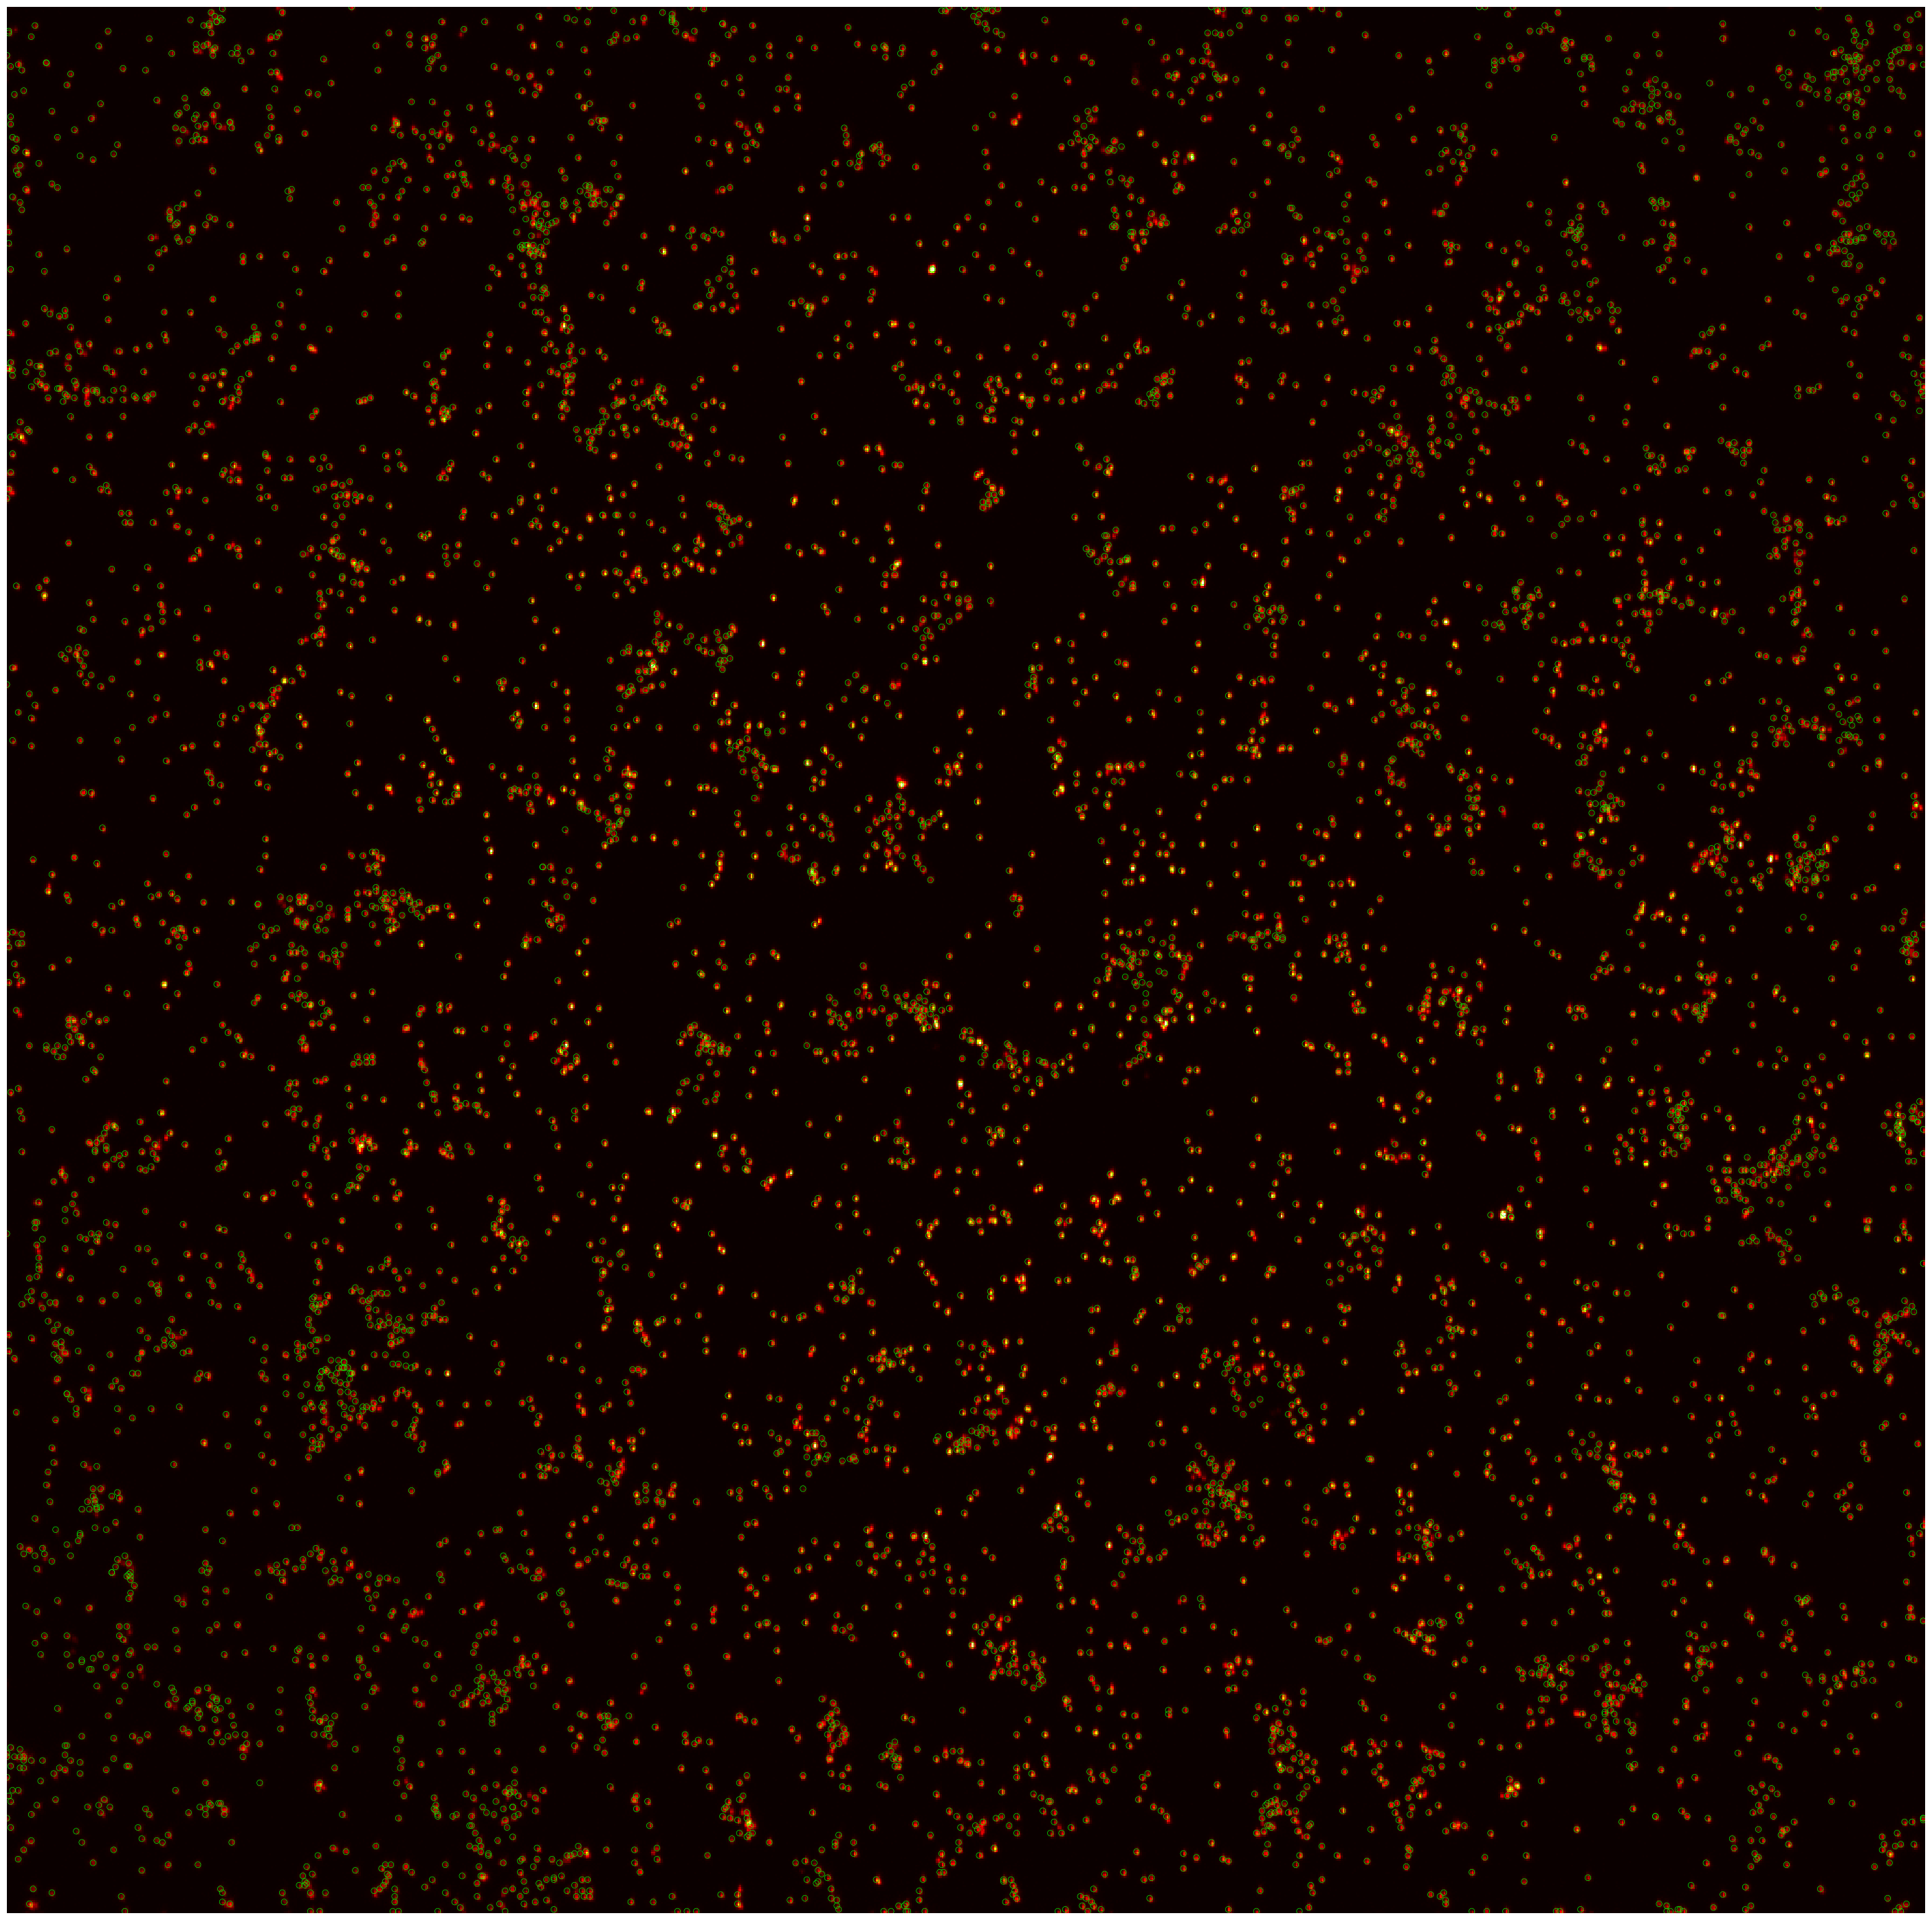

In [13]:
# Plot the identified peaks on the image
for path in paths:
    img_path = os.path.join(path_input, path)
    tbl_path = os.path.join(path_output, path.replace(".tif", ".csv"))
    out_path = os.path.join(path_figures, path.replace(".csv", "-figure.png"))
         
    img = tifffile.imread(img_path)
    img = np.max(img, axis=0)
    
    data = pd.read_csv(tbl_path)
    data.rename(columns = {"1":"y", "2":"x"}, inplace = True)
    data.loc[:, "y"] = img.shape[0] - data.loc[:, "y"]
    plt.clf()
    plt.set_cmap('hot')
    f, ax = plt.subplots(figsize=(36, 36))
    ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], aspect='auto')
    sns.scatterplot(x="x", y="y", facecolors = 'none', edgecolors = 'lime',
                data=data, ax=ax)
    ax.set_axis_off()
    f.savefig(out_path, bbox_inches='tight', pad_inches = 0)
    print((img_path, tbl_path, out_path))

In [15]:
header = ["z_px", "y_px", "x_px", "z_nm", "y_nm", "x_nm", "fwhm_z_px", "fwhm_y_px", "fwhm_x_px", "fwhm_z_nm", "fwhm_y_nm", "fwhm_x_nm"]
for path in paths:
    img_path = os.path.join(path_input, path)
    tbl_path = os.path.join(path_output, path.replace(".tif", ".csv"))
    out_path = os.path.join(path_fwhm, path.replace(".tif", "-fwhm.csv"))
    img = tifffile.imread(img_path)

    # Select pixel size according to the objective used
    obj = ob_re.match(path).group(1)
    px = PIXEL_SIZE[obj]
        
    peaks = pd.read_csv(tbl_path)
    peaks = np.asarray(peaks)
    results = np.concatenate((peaks, np.full((peaks.shape[0], 9), -1.0)), axis = 1)
    for i,p in enumerate(peaks):
         results[i,6] = signal.peak_widths(img[: ,p[1], p[2]], np.full((1), p[0]), rel_height=0.5, prominence_data=None, wlen=None)[0]
         results[i,7] = signal.peak_widths(img[p[0], :, p[2]], np.full((1), p[1]), rel_height=0.5, prominence_data=None, wlen=None)[0]
         results[i,8] = signal.peak_widths(img[p[0], p[1], :], np.full((1), p[2]), rel_height=0.5, prominence_data=None, wlen=None)[0]
    results[:, 3] = results[:, 0] * px[0]   # Peak coordinate Z 
    results[:, 4] = results[:, 1] * px[1]   # Peak coordinate Y 
    results[:, 5] = results[:, 2] * px[2]   # Peak coordinate X 
    results[:, 9] = results[:, 6] * px[0]   # Peak FWHM Z
    results[:, 10] = results[:, 7] * px[1]  # Peak FWHM Y
    results[:, 11] = results[:, 8] * px[2]  # Peak FWHM X
    
    df = pd.DataFrame(results, columns=header)
    df.to_csv(path_or_buf = out_path, sep=',', na_rep='',
              float_format=None, columns=None, header=True, index=False)

/tmp/ipykernel_227183/563191888.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[i,6] = signal.peak_widths(img[: ,p[1], p[2]], np.full((1), p[0]), rel_height=0.5, prominence_data=None, wlen=None)[0]
/tmp/ipykernel_227183/563191888.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  results[i,7] = signal.peak_widths(img[p[0], :, p[2]], np.full((1), p[1]), rel_height=0.5, prominence_data=None, wlen=None)[0]
/tmp/ipykernel_227183/563191888.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this 

In [ ]:
for path in paths:
    img_path = os.path.join(path_input, path)
    tbl_path = os.path.join(path_fwhm,  path.replace(".tif", "-fwhm.csv"))
    path_output = os.path.join(path_figures, path.replace(".tif", ""))
    if os.path.exists(path_output):
        print(path_output)
        continue
    os.makedirs(path_output, mode=0o777, exist_ok=True)
        
    
    img = tifffile.imread(img_path)
    data = pd.read_csv(tbl_path)
    data.loc[:, "y_px"] = img.shape[1] - data.loc[:, "y_px"]
    data.z_px = data.z_px.astype(int)
    data["big"] = data['big'] = np.where(data['fwhm_y_px'] > 8.8, 'big', 'small')
    data["sizes"] = data.fwhm_y_px **2 *3.14
    data.fwhm_y_px = data.fwhm_y_px.astype(int)
    color_map = {'small': 'lime', 'big': 'cyan'}
    data['color'] = data['big'].map(color_map)
      
    for cz in np.unique(data.z_px):
        zslice = data[data["z_px"] == cz]
        plt.clf()
        plt.set_cmap('hot')
        f, ax = plt.subplots(figsize=(36, 36))
        ax.imshow(img[cz,:,:], extent=[0, img.shape[2], 0, img.shape[1]], aspect='auto')
        ax.scatter(zslice.x_px, zslice.y_px, edgecolors=zslice.color, facecolors="none", label=zslice.big,
                  s = zslice.sizes, linewidths=0.25)
        ax.set_axis_off()
        out_path = os.path.join(path_output, str(cz) + "-" + path.replace(".tif", "-figure.png"))
        f.savefig(out_path, bbox_inches='tight', pad_inches = 0)
        plt.close()
        print((cz, img_path, tbl_path, out_path))

(3, './img_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', './fwhm_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-fwhm.csv', './figures_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405/3-Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-figure.png')
(4, './img_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', './fwhm_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-fwhm.csv', './figures_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405/4-Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-figure.png')
(5, './img_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', './fwhm_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-fwhm.csv', './figures_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405/5-Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405-figure.png')
(6, './img_RNAscope/Beads_300nm_rainbow_40X_2024-12-10_14.19.50_ch4_405.tif', './fwhm_RNAscope/Beads_300nm_ra